In [1]:
import tensorflow as tf
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import ipywidgets as widgets
#import matplotlib.animation as animation
#from matplotlib.widgets import Slider
#from IPython.display import HTML

%matplotlib inline

In [2]:
lungs_path = "/Users/dutking/LOCAL/AI_uni/radlogix/dataset/lungs_labels/LUNG1-097/LUNG1-097_thor_cav_primary_reviewer.nii.gz"
effusion_path = "/Users/dutking/LOCAL/AI_uni/radlogix/dataset/effusions_052023/LUNG1-097/LUNG1097_effusion_second_reviewer.nii.gz"
dicom_folder_path = "/Users/dutking/LOCAL/AI_uni/radlogix/dataset/features/LUNG1-097/02-26-2006-StudyID-NA-21320/0.000000-NA-40681"


In [3]:
def set_direction(image, coord):
    image = sitk.DICOMOrient(image, coord)
    return image


def get_feature(dicom_folder, coord="LPS"):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_folder)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image = sitk.DICOMOrient(image, coord)
    image_array = sitk.GetArrayFromImage(image)
    return image_array.astype(dtype=np.int16)


my_feature1 = get_feature(dicom_folder_path, "RPS")
my_feature2 = get_feature(dicom_folder_path, "LPS")
my_feature3 = get_feature(dicom_folder_path, "RPI")
my_feature4 = get_feature(dicom_folder_path, "LPI")
print("feature shape:", my_feature1.shape)


def get_label(file, coord="LPS"):
    image = sitk.ReadImage(file)
    image = sitk.DICOMOrient(image, coord)
    image_array = sitk.GetArrayFromImage(image)
    return image_array.astype(dtype=np.int16)


my_effusion1 = get_label(effusion_path, "RPS")
my_effusion2 = get_label(effusion_path, "LPS")
my_effusion3 = get_label(effusion_path, "RPI")
my_effusion4 = get_label(effusion_path, "LPI")
print("effusion shape:", my_effusion1.shape)

my_lungs1 = get_label(lungs_path, "RPS")
my_lungs2 = get_label(lungs_path, "LPS")
my_lungs3 = get_label(lungs_path, "RPI")
my_lungs4 = get_label(lungs_path, "LPI")
print("lungs shape:", my_lungs1.shape)


feature shape: (135, 512, 512)
effusion shape: (135, 512, 512)
lungs shape: (135, 512, 512)


In [4]:
"""
def animate(feature_arr, label_arr):
    fig = plt.figure()
    ims = []
    for image in range(0, feature_arr.shape[0], 1):
        im = plt.imshow(feature_arr[image, :, :], animated=True, cmap="bone")
        plt.axis("off")
        ims.append([im])

    ani = animation.ArtistAnimation(
        fig, ims, interval=100, blit=False, repeat_delay=1000
    )

    plt.close()
    HTML(ani.to_jshtml())


animate(my_feature)
"""


'\ndef animate(feature_arr, label_arr):\n    fig = plt.figure()\n    ims = []\n    for image in range(0, feature_arr.shape[0], 1):\n        im = plt.imshow(feature_arr[image, :, :], animated=True, cmap="bone")\n        plt.axis("off")\n        ims.append([im])\n\n    ani = animation.ArtistAnimation(\n        fig, ims, interval=100, blit=False, repeat_delay=1000\n    )\n\n    plt.close()\n    HTML(ani.to_jshtml())\n\n\nanimate(my_feature)\n'

In [5]:
def overlay_slices_slider(images, titles=[]):
    @widgets.interact(axial_slice=(0, images[0].shape[0] - 1))
    def axial_slicer(axial_slice=0):
        num_plots = len(images)
        if len(titles) < num_plots:
            diff = num_plots - len(titles)
            for i in range(diff):
                titles.append("")
        fig, ax = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), squeeze=False)
        ax[0][0].imshow(images[0][axial_slice, :, :], cmap="bone")
        ax[0][0].set_title(titles[0])
        ax[0][0].axis("off")
        for x in range(num_plots - 1):
            ax[0][x + 1].imshow(images[0][axial_slice, :, :], cmap="bone")
            ax[0][x + 1].imshow(
                images[x + 1][axial_slice, :, :],
                cmap="prism",
                alpha=0.5 * images[x + 1][axial_slice],
            )
            ax[0][x + 1].set_title(titles[x + 1])
            ax[0][x + 1].axis("off")
        plt.show()


In [6]:
overlay_slices_slider(
    images=[my_feature1, my_effusion1, my_lungs1], titles=["X", "Y", "Z"]
)
overlay_slices_slider(
    images=[my_feature2, my_effusion2, my_lungs2], titles=["X", "Y", "Z"]
)
overlay_slices_slider(
    images=[my_feature3, my_effusion3, my_lungs3], titles=["X", "Y", "Z"]
)
overlay_slices_slider(
    images=[my_feature4, my_effusion4, my_lungs4], titles=["X", "Y", "Z"]
)


interactive(children=(IntSlider(value=0, description='axial_slice', max=134), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=0, description='axial_slice', max=134), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=0, description='axial_slice', max=134), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=0, description='axial_slice', max=134), Output()), _dom_classes=('widget…

In [7]:
overlay_slices_slider(images=[my_feature1, my_effusion1], titles=["X", "Y"])


interactive(children=(IntSlider(value=0, description='axial_slice', max=134), Output()), _dom_classes=('widget…

(1, 256, 256, 1) (1, 256, 256, 1)
(1, 128, 128, 1) (1, 128, 128, 1)


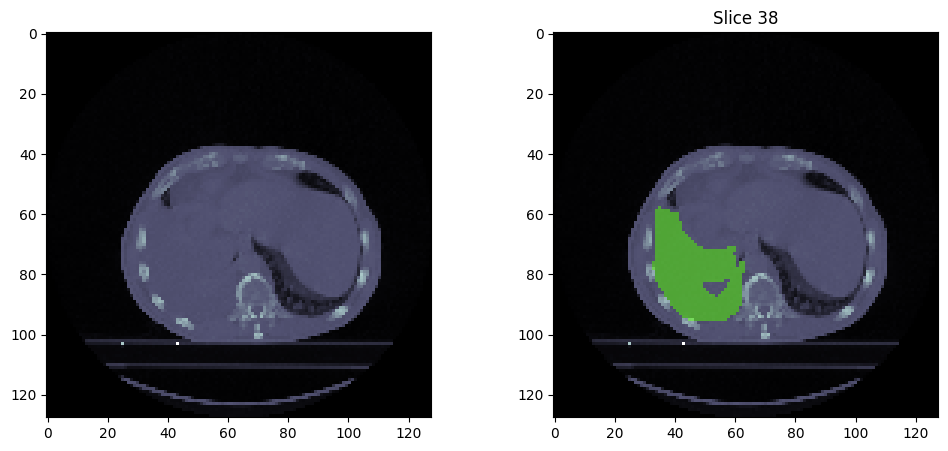

In [8]:
def plot_overlay(feature, label, slice_num):
    my_slice = None
    if slice_num:
        my_slice = slice_num
    else:
        my_slice = int(feature.shape[0] / 2)
    feature_slice = feature[my_slice, :, :]
    label_slice = np.squeeze(label[my_slice, :, :])
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    ax[0].imshow(feature_slice, cmap="bone", interpolation="none")
    ax[1].imshow(feature_slice, cmap="bone", interpolation="none")
    ax[1].imshow(
        label_slice, cmap="prism", vmin=0, vmax=1, alpha=0.5 * (np.squeeze(label_slice))
    )
    plt.title(f"Slice {my_slice}")
    plt.show()


def plot_overlay2(feature, label, slice_num):
    my_slice = None
    if slice_num:
        my_slice = slice_num
    else:
        my_slice = int(feature.shape[0] / 2)
    feature_slice = feature[my_slice, :, :]
    label_slice = label[my_slice, :, :]
    feature_slice = feature_slice.reshape((1, 512, 512, 1))
    label_slice = label_slice.reshape((1, 512, 512, 1))
    feature_slice = tf.keras.layers.MaxPooling2D(2)(feature_slice)
    label_slice = tf.keras.layers.MaxPooling2D(2)(label_slice)
    print(feature_slice.shape, label_slice.shape)
    feature_slice = tf.keras.layers.MaxPooling2D(2)(feature_slice)
    label_slice = tf.keras.layers.MaxPooling2D(2)(label_slice)
    print(feature_slice.shape, label_slice.shape)
    feature_slice = tf.squeeze(feature_slice)
    label_slice = tf.squeeze(label_slice)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    ax[0].imshow(feature_slice, cmap="bone", interpolation="none")
    ax[1].imshow(feature_slice, cmap="bone", interpolation="none")
    ax[1].imshow(
        label_slice, cmap="prism", vmin=0, vmax=1, alpha=0.5 * (np.squeeze(label_slice))
    )
    plt.title(f"Slice {my_slice}")
    plt.show()


plot_overlay2(my_feature1, my_effusion1, 38)


In [9]:
def plot_3d(
    images,
    labels=["Lungs", "Effusion"],
    colors=["navy", "orange"],
    alpha=[0.2, 0.5],
    threshold=[-600, 0],
):
    """
    Эта функция создает 3D визуализацию изображения на основе заданного порогового значения.
    Параметры:
    images: [ndarray]
        3D массив, представляющий изображения.
    labels: [str]
        Подписи к графикам
    colors: [float | str]
        Массив значений цвета фигур.
    alpha: [float]
        Массив значеий прозрачности фигур.
    threshold: [int], необязательный
        Пороговое значение, используемое для создания 3D модели.
    """
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111, projection="3d")
    patches = []
    for idx, image in enumerate(images):
        # Расположим сканирование вертикально,
        # так чтобы голова пациента была вверху, лицом к камере
        image = image.transpose(2, 0, 1)
        image = image[:, :, ::-1]

        if idx == 0:
            # Устанавливаем границы для каждой оси в соответствии с формой транспонированного изображения
            ax.set_xlim(0, image.shape[0])
            ax.set_ylim(0, image.shape[1])
            ax.set_zlim(0, image.shape[2])

        # Получаем вершины и грани 3D модели, используя marching_cubes
        verts, faces, _, _ = measure.marching_cubes(image, threshold[idx])
        # Создаем объект Figure в matplotlib и добавляем в него 3D подзаголовок

        # Создаем коллекцию треугольников из вершин и граней, устанавливаем цвет и прозрачность, добавляем в подзаголовок
        mesh = Poly3DCollection(verts[faces], alpha=alpha[idx])
        face_color = colors[idx]
        mesh.set_facecolor(face_color)
        ax.add_collection3d(mesh)
        # Patch to add legend
        patches.append(mpatches.Patch(color=colors[idx], label=labels[idx]))
    ax.legend(handles=patches)

    # Отображаем визуализацию
    plt.show()


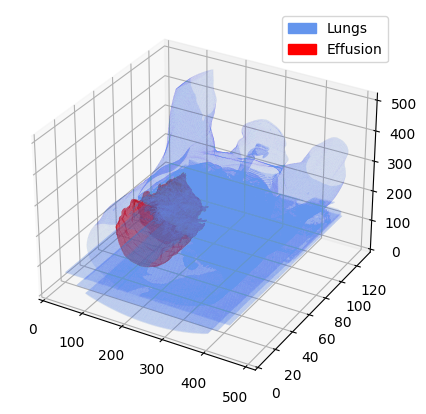

In [11]:
plot_3d(
    [my_feature1, my_effusion1],
    threshold=[-600, 0],
    alpha=[0.2, 0.5],
    colors=["cornflowerblue", "red"],
)
